In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from seaborn import pairplot
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [4]:
# Select the seasons data we want

YEAR = [2017,2018,2019,2020,2021]

df = pd.DataFrame()

for year in YEAR:
    data = pd.read_csv(
    'https://github.com/guga31bb/nflfastR-data/blob/master/data/play_by_play_' \
    + str(year) + '.csv.gz?raw=True',compression='gzip', low_memory=False
    )

    df = df.append(data)


In [5]:
df['fixed_drive_result']

0           Turnover
1           Turnover
2           Turnover
3           Turnover
4           Turnover
            ...     
26841      Touchdown
26842    End of half
26843    End of half
26844    End of half
26845    End of half
Name: fixed_drive_result, Length: 219265, dtype: object

In [296]:
#total_plays = df.loc[:,['game_id','posteam','drive_play_count']].drop_duplicates().reset_index().drop(columns = 'index').dropna()
#total_plays.head()

In [6]:
# avg epa/play for home and away teams for a given game (game_id)

home_epa_play = df.groupby(['game_id']).apply(lambda x: x[x['posteam'] == x['home_team']]['epa'].mean()).reset_index().rename(columns = {0:'home_epa_play'})
away_epa_play = df.groupby(['game_id']).apply(lambda x: x[x['posteam'] == x['away_team']]['epa'].mean()).reset_index().rename(columns = {0:'away_epa_play'})
home_cpoe = df.groupby(['game_id']).apply(lambda x: x[x['posteam'] == x['home_team']]['cpoe'].mean()).reset_index().rename(columns = {0:'home_cpoe'})
away_cpoe = df.groupby(['game_id']).apply(lambda x: x[x['posteam'] == x['away_team']]['cpoe'].mean()).reset_index().rename(columns = {0:'away_cpoe'})

home_epa_play.head()

,game_id,home_epa_play
0,2017_01_ARI_DET,-0.176459
1,2017_01_ATL_CHI,0.037828
2,2017_01_BAL_CIN,-0.456534
3,2017_01_CAR_SF,-0.341723
4,2017_01_IND_LA,0.123172


In [7]:
epa = pd.merge(home_epa_play,away_epa_play)
epa.head()

,game_id,home_epa_play,away_epa_play
0,2017_01_ARI_DET,-0.176459,-0.276700
1,2017_01_ATL_CHI,0.037828,0.192672
2,2017_01_BAL_CIN,-0.456534,-0.078383
3,2017_01_CAR_SF,-0.341723,0.008913
4,2017_01_IND_LA,0.123172,-0.402455


In [10]:
cpoe = pd.merge(home_cpoe,away_cpoe)
cpoe.head()

,game_id,home_cpoe,away_cpoe
0,2017_01_ARI_DET,5.455871,-6.262744
1,2017_01_ATL_CHI,-0.905183,5.759217
2,2017_01_BAL_CIN,-10.868333,-9.848655
3,2017_01_CAR_SF,2.307927,-4.255375
4,2017_01_IND_LA,8.388153,-7.657432


In [21]:
total_plays = df.loc[:,['play_id','game_id','posteam','cpoe','home_team','away_team','drive_play_count']].drop_duplicates().reset_index().drop(columns = 'index').dropna()
total_plays.head(20)

,play_id,game_id,posteam,cpoe,home_team,away_team,drive_play_count
2,73,2017_01_ARI_DET,ARI,12.008733,DET,ARI,6.0
4,118,2017_01_ARI_DET,ARI,29.053855,DET,ARI,6.0
6,174,2017_01_ARI_DET,ARI,-72.663134,DET,ARI,6.0
7,207,2017_01_ARI_DET,ARI,-67.755991,DET,ARI,6.0
9,254,2017_01_ARI_DET,DET,-79.124004,DET,ARI,2.0
13,337,2017_01_ARI_DET,DET,18.159825,DET,ARI,3.0
14,361,2017_01_ARI_DET,DET,-34.998801,DET,ARI,3.0
16,408,2017_01_ARI_DET,ARI,12.078100,DET,ARI,3.0
21,533,2017_01_ARI_DET,DET,18.277258,DET,ARI,4.0
26,694,2017_01_ARI_DET,ARI,-48.060843,DET,ARI,7.0


In [22]:
##the drive_play_count creates a duplication of totality plays. i.e. there were 11 plays in the drive so each row in that particular drive will say 11 even though they should count as 1
## suggest using play_id to get a more accurate count of actual plays
home_plays = total_plays.groupby(['game_id']).apply(lambda x: x[x['posteam'] == x['home_team']]['play_id'].count()).reset_index().rename(columns = {0:'home_plays'})
away_plays = total_plays.groupby(['game_id']).apply(lambda x: x[x['posteam'] == x['away_team']]['play_id'].count()).reset_index().rename(columns = {0:'away_plays'})

In [23]:
home_plays.head(20)

,game_id,home_plays
0,2017_01_ARI_DET,39
1,2017_01_ATL_CHI,40
2,2017_01_BAL_CIN,29
3,2017_01_CAR_SF,35
4,2017_01_IND_LA,30
5,2017_01_JAX_HOU,36
6,2017_01_KC_NE,36
7,2017_01_LAC_DEN,28
8,2017_01_NO_MIN,32
9,2017_01_NYG_DAL,38


In [24]:
away_plays.head(20)

,game_id,away_plays
0,2017_01_ARI_DET,47
1,2017_01_ATL_CHI,30
2,2017_01_BAL_CIN,17
3,2017_01_CAR_SF,24
4,2017_01_IND_LA,21
5,2017_01_JAX_HOU,21
6,2017_01_KC_NE,34
7,2017_01_LAC_DEN,33
8,2017_01_NO_MIN,37
9,2017_01_NYG_DAL,38


After inspecting the data, it seems that the driveplay count discounts the special teams plays, penalized plays, etc.  which is why the numbers dont add up when 
comparing to ESPN plays..  so data is OK

In [25]:
# get all the final scores since 2011

game_scores = df.loc[:,['play_id', 'game_id','home_score','away_score','total']].drop_duplicates().reset_index().drop(columns = 'index')
game_scores.head()

,play_id,game_id,home_score,away_score,total
0,1,2017_01_ARI_DET,35,23,58
1,37,2017_01_ARI_DET,35,23,58
2,73,2017_01_ARI_DET,35,23,58
3,97,2017_01_ARI_DET,35,23,58
4,118,2017_01_ARI_DET,35,23,58


In [26]:
plays_count = pd.merge(home_plays, away_plays)
plays_count.head()

,game_id,home_plays,away_plays
0,2017_01_ARI_DET,39,47
1,2017_01_ATL_CHI,40,30
2,2017_01_BAL_CIN,29,17
3,2017_01_CAR_SF,35,24
4,2017_01_IND_LA,30,21


In [28]:
merge_1 = pd.merge(game_scores,epa)
merge_1.head()

,play_id,game_id,home_score,away_score,total,home_epa_play,away_epa_play
0,1,2017_01_ARI_DET,35,23,58,-0.176459,-0.2767
1,37,2017_01_ARI_DET,35,23,58,-0.176459,-0.2767
2,73,2017_01_ARI_DET,35,23,58,-0.176459,-0.2767
3,97,2017_01_ARI_DET,35,23,58,-0.176459,-0.2767
4,118,2017_01_ARI_DET,35,23,58,-0.176459,-0.2767


In [30]:
merge_2 = pd.merge(merge_1, cpoe)
merge_2.head(20)

,play_id,game_id,home_score,away_score,total,home_epa_play,away_epa_play,home_cpoe,away_cpoe
0,1,2017_01_ARI_DET,35,23,58,-0.176459,-0.2767,5.455871,-6.262744
1,37,2017_01_ARI_DET,35,23,58,-0.176459,-0.2767,5.455871,-6.262744
2,73,2017_01_ARI_DET,35,23,58,-0.176459,-0.2767,5.455871,-6.262744
3,97,2017_01_ARI_DET,35,23,58,-0.176459,-0.2767,5.455871,-6.262744
4,118,2017_01_ARI_DET,35,23,58,-0.176459,-0.2767,5.455871,-6.262744
5,153,2017_01_ARI_DET,35,23,58,-0.176459,-0.2767,5.455871,-6.262744
6,174,2017_01_ARI_DET,35,23,58,-0.176459,-0.2767,5.455871,-6.262744
7,207,2017_01_ARI_DET,35,23,58,-0.176459,-0.2767,5.455871,-6.262744
8,233,2017_01_ARI_DET,35,23,58,-0.176459,-0.2767,5.455871,-6.262744
9,254,2017_01_ARI_DET,35,23,58,-0.176459,-0.2767,5.455871,-6.262744


QUICK VIEW OF HOW EPA/PLAY EFFECTS THE TOTAL

In [31]:
## Arizona had less plays, scored more, lesser negative variance in epa
## and higher CPOE with a positive value = could indicate a greater
## more effective offensive performance which resulted in a WIN,
## and Detroit was handicapped by a solid defensive performance due to their more negative epa and negative CPOE

test_df = pd.merge(merge_2, plays_count)
test_df.head()

,play_id,game_id,home_score,away_score,total,home_epa_play,away_epa_play,home_cpoe,away_cpoe,home_plays,away_plays
0,1,2017_01_ARI_DET,35,23,58,-0.176459,-0.2767,5.455871,-6.262744,39,47
1,37,2017_01_ARI_DET,35,23,58,-0.176459,-0.2767,5.455871,-6.262744,39,47
2,73,2017_01_ARI_DET,35,23,58,-0.176459,-0.2767,5.455871,-6.262744,39,47
3,97,2017_01_ARI_DET,35,23,58,-0.176459,-0.2767,5.455871,-6.262744,39,47
4,118,2017_01_ARI_DET,35,23,58,-0.176459,-0.2767,5.455871,-6.262744,39,47


In [32]:
# what is the significance of total plays here?
test_df['total_plays'] = test_df['home_plays'] + test_df['away_plays']
test_df.head()

,play_id,game_id,home_score,away_score,total,home_epa_play,away_epa_play,home_cpoe,away_cpoe,home_plays,away_plays,total_plays
0,1,2017_01_ARI_DET,35,23,58,-0.176459,-0.2767,5.455871,-6.262744,39,47,86
1,37,2017_01_ARI_DET,35,23,58,-0.176459,-0.2767,5.455871,-6.262744,39,47,86
2,73,2017_01_ARI_DET,35,23,58,-0.176459,-0.2767,5.455871,-6.262744,39,47,86
3,97,2017_01_ARI_DET,35,23,58,-0.176459,-0.2767,5.455871,-6.262744,39,47,86
4,118,2017_01_ARI_DET,35,23,58,-0.176459,-0.2767,5.455871,-6.262744,39,47,86


<AxesSubplot:xlabel='home_score', ylabel='home_epa_play'>

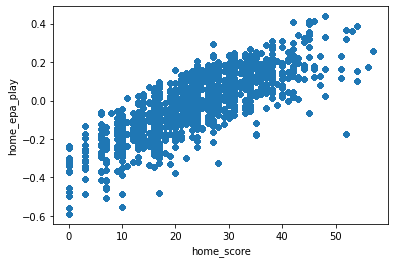

In [46]:
# potential relation, mean of the epa for the home team, 
# if they go into the game with a +0.4 baseline EPA = maybe puts up 40-60 points?
# potential 2 boxplots with a side by side comparison could be valuable? shows a 1for1 relationship
test_df.plot.scatter(x='home_score',y='home_epa_play')

In [39]:
# test_df.plot.scatter(x='home_score',y='home_cpoe')

<AxesSubplot:xlabel='away_score', ylabel='away_epa_play'>

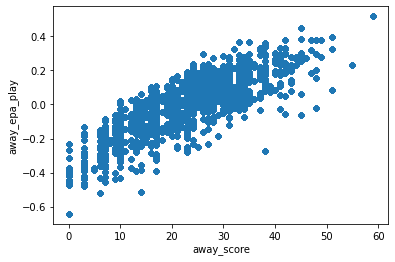

In [40]:
test_df.plot.scatter(x='away_score',y='away_epa_play')

In [313]:
#test_df.plot.scatter(x='away_score',y='away_cpoe')

In [314]:
#test_df.plot.scatter(x='total',y='home_cpoe')

CPOE doesnt seem to have an effect on total score, not much of an effect on team total score

In [315]:
#test_df.plot.scatter(x = 'home_plays', y = 'home_score')


In [316]:
#test_df.plot.scatter(x = 'away_plays', y = 'away_score')

In [317]:
#test_df.plot.scatter(x = 'total_plays', y = 'total')

Also appears to be no real correlation btwn total plays and team score ... 

will continue with epa/play and team totals for this ML model --  but keep cpoes in the data

In [319]:
# add team avg points scored columns

#test_df['2_game_avg'] = test_df.total.rolling(window=2).mean()
#test_df['4_game_avg'] = test_df.total.rolling(window=4).mean()
#test_df['6_game_avg'] = test_df.total.rolling(window=6).mean()

In [410]:
# create the dataset to use for this machine learning model
ml_df = test_df.drop(['home_plays','away_plays','total_plays','home_cpoe','away_cpoe'], axis = 1)
#ml_df.head()

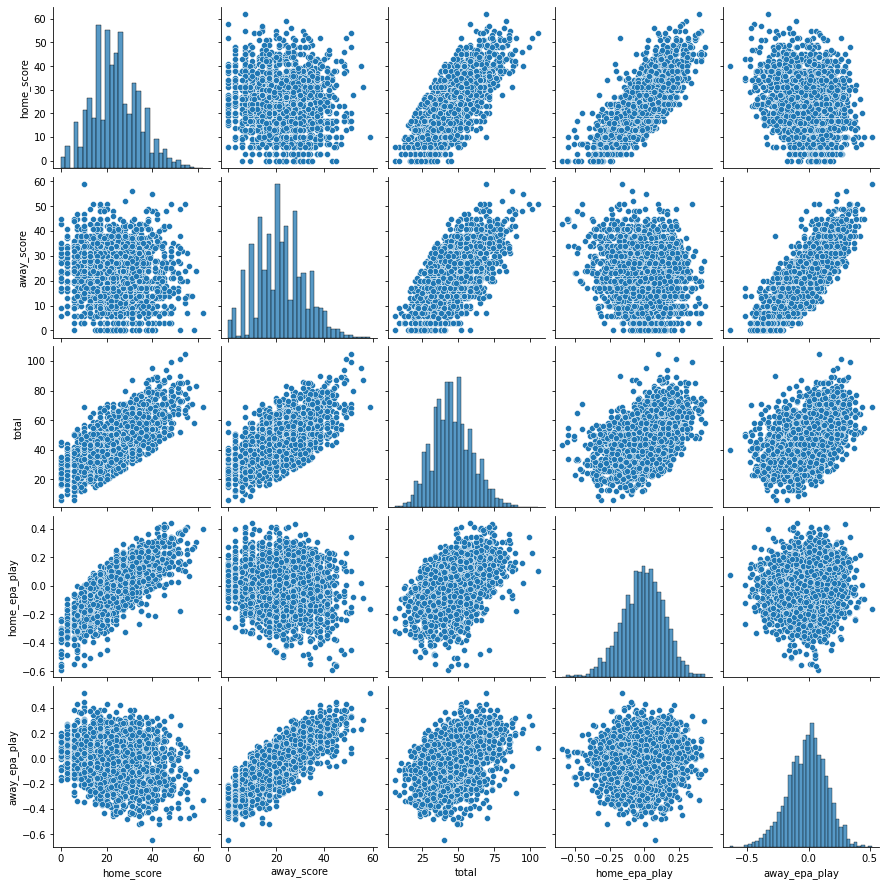

In [411]:
pairplot(ml_df)

In [322]:
corr = ml_df.corr()
corr

,home_score,away_score,total,home_epa_play,away_epa_play,home_cpoe,away_cpoe
home_score,1.000000,-0.047034,0.703708,0.781019,-0.174290,0.457237,-0.128142
away_score,-0.047034,1.000000,0.676604,-0.159055,0.791880,-0.135398,0.460632
total,0.703708,0.676604,1.000000,0.462606,0.434765,0.240752,0.233175
home_epa_play,0.781019,-0.159055,0.462606,1.000000,0.110642,0.562790,0.036399
away_epa_play,-0.174290,0.791880,0.434765,0.110642,1.000000,0.007507,0.572130
home_cpoe,0.457237,-0.135398,0.240752,0.562790,0.007507,1.000000,0.001924
away_cpoe,-0.128142,0.460632,0.233175,0.036399,0.572130,0.001924,1.000000


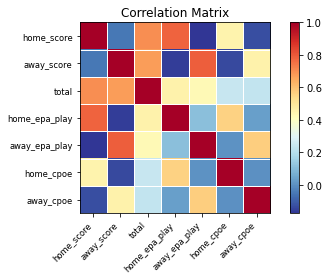

In [323]:
from statsmodels.graphics.correlation import plot_corr

correlation_viz = plot_corr(corr, xnames = corr.columns) 

In [382]:
# create features and targets for ml

#X = pd.DataFrame(ml_df, columns = ['home_epa_play', 'total'])
#y = pd.DataFrame(ml_df, columns=['home_score'])




In [398]:
train, test = train_test_split(ml_df, test_size=0.2)
lin_reg = LinearRegression()

trained_data = lin_reg.fit(train[['home_epa_play','total']], train[['home_score']])
rsqr = trained_data.score(train[['home_epa_play','total']], train[['home_score']])
rsqr


0.7566449006377282

In [399]:
test['pred_home_score'] = trained_data.predict(test[['home_epa_play','total']])
test['resid'] = test['home_score'] - test['pred_home_score']
test

/Users/tcjurgens/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/tcjurgens/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,game_id,home_score,away_score,total,home_epa_play,away_epa_play,home_cpoe,away_cpoe,pred_home_score,resid
23,2011_02_HOU_MIA,13,23,36,-0.156186,0.016863,-15.330085,20.952066,14.987915,-1.987915
125,2011_09_NYJ_BUF,11,27,38,-0.113986,0.145059,-9.652656,6.858464,17.282670,-6.282670
2163,2019_03_DEN_GB,27,16,43,0.056433,-0.083566,-4.597573,0.583640,25.576695,1.423305
2525,2020_09_SEA_BUF,44,34,78,0.182185,0.076285,16.168786,7.135822,41.598608,2.401392
2488,2020_07_DAL_WAS,25,3,28,0.114267,-0.188017,6.469828,-15.760793,23.111110,1.888890
...,...,...,...,...,...,...,...,...,...,...
1034,2014_17_CHI_MIN,13,9,22,-0.091710,-0.110476,0.210079,-5.133607,13.100206,-0.100206
2136,2019_01_LA_CAR,27,30,57,-0.116054,-0.025640,-1.815383,-4.557547,23.209853,3.790147
96,2011_07_IND_NO,62,7,69,0.396316,-0.330296,20.079048,-3.874807,47.187061,14.812939
1357,2016_03_ARI_BUF,33,18,51,-0.101391,-0.233725,-7.785322,-7.551661,21.889962,11.110038


In [403]:
train, test = train_test_split(ml_df, test_size=0.2)
lin_reg = LinearRegression()

home_train = lin_reg.fit(train[['home_epa_play','total']], train[['home_score']])
away_train = lin_reg.fit(train[['away_epa_play','total']], train[['away_score']])



In [409]:
test['pred_home_score'] = trained_data.predict(test[['home_epa_play','total']])
test['pred_away_score'] = trained_data.predict(test[['away_epa_play','total']])
test['pred_total'] = test['pred_home_score'] + test['pred_away_score']
test

/Users/tcjurgens/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/tcjurgens/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/tcjurgens/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

,game_id,home_score,away_score,total,home_epa_play,away_epa_play,home_cpoe,away_cpoe,pred_home_score,pred_away_score,pred_total
2744,2021_06_CIN_DET,11,34,45,-0.171838,0.176797,-2.789405,-0.984361,17.217606,30.950331,48.167938
462,2012_14_CHI_MIN,21,14,35,-0.051987,-0.108836,-1.727380,-6.939410,18.776078,16.536791,35.312869
1737,2017_10_SEA_ARI,16,22,38,-0.121230,-0.047666,-9.816226,6.272115,16.997339,19.895033,36.892372
2211,2019_06_NYG_NE,35,14,49,-0.119225,-0.515060,6.192063,-9.647584,20.554994,4.963056,25.518049
1772,2017_13_HOU_TEN,24,13,37,0.172012,0.031405,7.244612,3.598450,28.231882,22.693377,50.925258
...,...,...,...,...,...,...,...,...,...,...,...
2152,2019_02_NE_MIA,0,43,43,-0.590694,0.077475,-16.102393,9.017643,0.086355,26.405543,26.491899
64,2011_05_ARI_MIN,34,10,44,-0.071120,-0.310088,-20.515275,-15.886902,20.868647,11.455660,32.324306
2697,2021_03_CAR_HOU,9,24,33,-0.151644,0.112028,6.143577,-0.280814,14.218113,24.604156,38.822269
2513,2020_09_CAR_KC,33,31,64,0.240312,0.174624,5.581863,15.458139,39.460822,36.873370,76.334192


<AxesSubplot:>

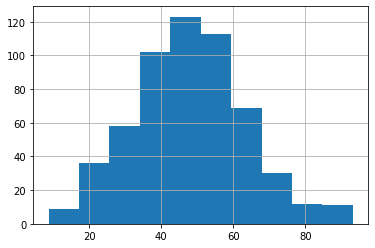

In [412]:
test.pred_total.hist()

In [424]:
spreads_totals = df[['game_id','season','home_team','away_team','total_line','spread_line']].drop_duplicates()

In [435]:
full_data = pd.merge(spreads_totals,test)
full_data.head()

,game_id,season,home_team,away_team,total_line,spread_line,home_score,away_score,total,home_epa_play,away_epa_play,home_cpoe,away_cpoe,pred_home_score,pred_away_score,pred_total
0,2011_01_NO_GB,2011,GB,NO,47.5,4.5,42,34,76,0.254468,0.187244,17.569486,3.739695,43.813363,41.165404,84.978767
1,2011_01_PHI_STL,2011,LA,PHI,44.0,-3.5,13,31,44,-0.157291,0.097437,-13.137951,-7.094290,17.474369,27.508103,44.982472
2,2011_01_TEN_JAX,2011,JAX,TEN,38.0,-1.0,16,14,30,-0.005363,-0.014312,3.102251,3.140508,19.031370,18.678865,37.710235
3,2011_02_ARI_WAS,2011,WAS,ARI,44.5,4.5,22,21,43,0.033603,0.058476,-5.128386,-7.562582,24.677413,25.657165,50.334578
4,2011_02_BAL_TEN,2011,TEN,BAL,39.5,-5.5,26,13,39,0.060985,-0.097828,9.538084,-10.317162,24.491035,18.235385,42.726419


In [ ]:
# next, want to figure out a way to use the vegas total_line and the teams playing epa_play over the last however many games to predict the home and away scores.